In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc3 as pm
import theano.tensor as T
import theano
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Bayesian Neural Network in PyMC3

Why? . . .

In [54]:
X, y = make_circles(factor = 0.5, random_state = 42, noise = 0.05, n_samples=1000)
X.shape, y.shape

<AxesSubplot:>

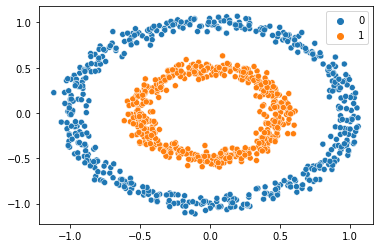

In [59]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30)

In [65]:
# Turning inputs and outputs into shared variables so we can change them later
nn_input, nn_output = theano.shared(X_train), theano.shared(y_train)

# Number of hidden "neurons"
n_hidden = 5

# Random weight vectors
# Input --> Hidden layer 1
init_1 = np.random.randn(X.shape[1], n_hidden)
# Hidden layer 1 --> hidden layer 2
init_2 = np.random.randn(n_hidden, n_hidden)
# Hidden layer 2 --> output
init_out = np.random.randn(n_hidden)

with pm.Model() as neural_network:

    # Specify weights for input --> hidden layer 1
    weights_1 = pm.Normal('weights_1', 0, sd=1,
                          shape=(X.shape[1], n_hidden),
                          testval=init_1)

    # Specify weights for hidden layer 1 --> hidden layer 2
    weights_2 = pm.Normal('weights_2', 0, sd=1,
                          shape=(n_hidden, n_hidden),
                          testval=init_2)

    # Specify weights for hidden layer 2 --> output
    weights_out = pm.Normal('weights_out', 0, sd=1,
                          shape=(n_hidden),
                          testval=init_out)

    # Building the network with activation functions
    act_1 = T.tanh(T.dot(nn_input, weights_1))
    act_2 = T.tanh(T.dot(act_1, weights_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_out))

    # Output is a Bernoulli distribution [0, 1] in which we feed the observed classes (y_train)
    output = pm.Bernoulli('out', act_out, observed=nn_output)

In [66]:
with neural_network:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)[5000:]

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [weights_out]
>Metropolis: [weights_2]
>Metropolis: [weights_1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 58 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## Predictions

In [68]:
nn_input.set_value(X_test), nn_output.set_value(y_test)

# Generate posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=500)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [75]:
preds = ppc['out'].mean(axis=0) > 0.5
print('Accuracy = ', (y_test == preds).mean()*100)

Accuracy =  47.0
